In [1]:
# Import Distributions to generate random numbers W matrix of the RBM
using Distributions
using MNIST
using BenchmarkTools
using PyPlot
using Combinatorics

In [2]:
function generate_M(W, n_columns)

    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns))   

    print("\ncostat: ",costat,
          " \nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    M = zeros(costat * n_rows, costat * n_columns)
    
    n_im = 1
    for r in 1:costat:size(M)[1]
        for c in 1:costat:size(M)[2]
            M[r:r+costat-1, c:c+costat-1] = reshape(W[n_im,:],costat,costat)
            n_im +=1
        end
    end
    return M
end

generate_M (generic function with 1 method)

In [3]:
#sample([1,1,1], Distributions.Gaussian(1))

In [4]:
type RBM{T <: Real}
    n_vis::Int
    n_hid::Int
    W::Matrix{T}         
    vis_bias::Vector{T}     
    hid_bias::Vector{T}   
    trained::Bool
end

function Base.show{T}(io::IO, rbm::RBM{T})
    n_vis = size(rbm.vis_bias, 1)
    n_hid = size(rbm.hid_bias, 1)
    trained = rbm.trained
    print(io, "RBM{$T}(n_vis=$n_vis, n_hid=$n_hid, trained=$trained)")
end

In [5]:
function sigmoid(x::Float32)
    return 1/(1 + exp(-x))
end

sigmoid (generic function with 1 method)

In [6]:
function initialize_RBM(n_vis, n_hid, sigma, T)
    
    return RBM{T}( n_vis,                                 # num visible units 
                   n_hid,                                 # num hidden unnits
                   rand(Normal(0,sigma), n_hid, n_vis),  # weight matrix
                   zeros(n_vis),                          # visible vector  
                   zeros(n_hid),                          # Hidden vector
                   false)                                 # trained
end

initialize_RBM (generic function with 1 method)

In [7]:
function generate_M(W, n_columns)

    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns) )   

    print("\ncostat: ", costat,
          "\nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    M = zeros(costat * n_rows, costat * n_columns)
    
    n_im = 1
    for r in 1:costat:size(M)[1]
        for c in 1:costat:size(M)[2]
            M[r:r+costat-1, c:c+costat-1] = reshape(W[n_im,:],costat,costat)
            n_im +=1
        end
    end
    #M .= (M .- minimum(M)) ./ (maximum(M).- minimum(M))
    return M
end

generate_M (generic function with 1 method)

In [8]:
rbm = initialize_RBM(784, 100, 0.01, Float32)

RBM{Float32}(n_vis=784, n_hid=100, trained=false)


costat: 28

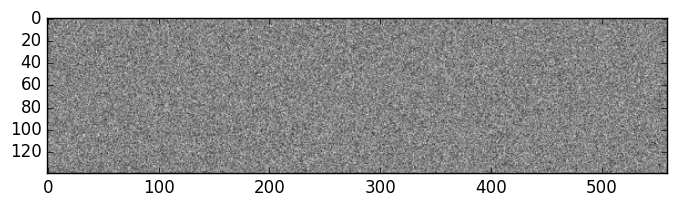


n_rows: 5
n_cols: 20

In [9]:
M = generate_M(rbm.W, 20)
PyPlot.imshow(M,"gray")

In [10]:
X_train, y_train = MNIST.traindata()
X_test, y_test = MNIST.testdata()


T = Float32
X_train = Array{T}( (X_train - minimum(X_train))/(maximum(X_train) - minimum(X_train)) )
y_train = Array{T}(y_train)
X_test = Array{T}(X_test - minimum(X_test))/(maximum(X_test) - minimum(X_test)) 
y_test = Array{T}(y_test);

In [11]:
minimum(X_train), maximum(X_train)

(0.0f0,1.0f0)

In [12]:
function vec_contrastive_divergence_K(Xbatch, rbm, K::Integer, lr::Real, T)
    
    Xneg = copy(Xbatch)
    batch_size = size(Xbatch)[2]
    
    local Hneg::Array{T} = zeros(rbm.n_hid, batch_size)
    local Xneg::Array{T} = zeros(rbm.n_vis, batch_size)
    local Ehp::Array{T} = zeros(rbm.n_hid, batch_size)
    local Ehn::Array{T} = zeros(rbm.n_hid, batch_size)
    
    for k in 1:K
        Hneg .= sigmoid.(rbm.W * Xneg .+ rbm.hid_bias) .> rand()
        Xneg .= sigmoid.(rbm.W' * Hneg  .+ rbm.vis_bias) .> rand()
    end
       
    Ehp .= sigmoid.(rbm.W * Xbatch .+ rbm.hid_bias)
    Ehn .= sigmoid.(rbm.W * Xneg .+ rbm.hid_bias)
    
    rbm.W .+= lr.*( Ehp * Xbatch' .-  Ehn *  Xneg') ./ batch_size;
    rbm.vis_bias .+= sum(lr .* (Xbatch .- Xneg), 2)[:]./ batch_size;
    rbm.hid_bias .+= sum(lr .* (Ehp .- Ehn), 2)[:] ./ batch_size;
end

vec_contrastive_divergence_K (generic function with 1 method)

In [13]:
X_batch = X_train[:,1:25]
@benchmark vec_contrastive_divergence_K(X_batch, rbm, 1, 0.01, T)

BenchmarkTools.Trial: 
  memory estimate:  2.68 MiB
  allocs estimate:  326
  --------------
  minimum time:     1.756 ms (0.00% GC)
  median time:      2.434 ms (0.00% GC)
  mean time:        3.707 ms (3.26% GC)
  maximum time:     43.431 ms (0.00% GC)
  --------------
  samples:          1337
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [14]:
function vec_fit_CDK(X, rbm, batch_size::Integer,  n_epochs::Integer, K::Integer, lr::Real,T)
        
    n_samples = size(X)[2]
    indicies = [x:min(x + batch_size-1, n_samples) for x in 1:batch_size:n_samples]
    sample_perm = Vector(1:n_samples)
    mb = 1
    for epoch in 1:n_epochs
        shuffle!(sample_perm)
        X = X[:,sample_perm]
        
        for minibatch_ind in indicies
            vec_contrastive_divergence_K(X[:, minibatch_ind], rbm, K, lr,T)
        end
    end
    rbm.trained = true
end

vec_fit_CDK (generic function with 1 method)

In [21]:
n_epochs = 1
batch_size = 500
K = 1
lr = 0.01

@time vec_fit_CDK(X_train, rbm, batch_size,  n_epochs, K, lr, T)

LoadError: InterruptException:

## Train model several epochs 

Plot the weights after training

In [22]:
rbm = initialize_RBM(784, 100, 0.01, Float32)
M = generate_M(rbm.W,25);
PyPlot.imshow(M,"gray")


costat: 28
n_rows: 4
n_cols: 25

InterruptException: InterruptException:

In [ ]:
n_epochs = 20
batch_size = 200
K = 1
lr = 0.001

vec_fit_CDK(X_train, rbm, batch_size,  n_epochs, K, lr, T)

In [ ]:
maximum(M), minimum(M)

In [ ]:
M = generate_M(rbm.W, 20);
PyPlot.imshow(M,"gray")

In [ ]:
PyPlot.imshow(M,"gray", vmin=minimum(M), vmax = maximum(M))


#### Using higher K

In [ ]:
n_epochs = 100
batch_size = 200
K = 5
lr = 0.001

vec_fit_CDK(X_train, rbm, batch_size,  n_epochs, K, lr, T)

In [ ]:
M = generate_M(rbm.W, 20);
PyPlot.imshow(M,"gray", vmin=minimum(M), vmax = maximum(M))

In [ ]:
# https://github.com/dfdx/Boltzmann.jl/blob/master/examples/mnistexample.jl

function plot_weights(W, imsize)
    padding=10
    
    h, w = imsize
    n = size(W, 1)
    rows = Int(floor(sqrt(n)))
    cols = Int(ceil(n / rows))
    halfpad = div(padding, 2)
    dat = zeros(rows * (h + padding), cols * (w + padding))
    for i=1:n
        wt = W[i, :]
        wim = reshape(wt, imsize)
        wim = wim ./ (maximum(wim) - minimum(wim))
        r = div(i - 1, cols) + 1
        c = rem(i - 1, cols) + 1
        dat[(r-1)*(h+padding)+halfpad+1 : r*(h+padding)-halfpad,
            (c-1)*(w+padding)+halfpad+1 : c*(w+padding)-halfpad] = wim
    end
    ImageView.view(dat)
    return dat
end

In [ ]:
using ImageView
#Pkg.add("ImageView")
#Pkg.update()

In [ ]:
size(rbm.W[1:10,:])

In [ ]:
plot_weights(rbm.W[1:64,:], (28,28))

In [ ]:
size(rbm.W[1:64,:])

## Scaling individually the features of the plot

#### Python code for printing the feature detectors


    for i, comp in enumerate(self.W.T):
        plt.subplot(15, 15, i + 1)
        if min_max_scale:
            plt.imshow(comp.reshape((28, 28)),
                       cmap= plt.get_cmap('gray'), vmin=min_, vmax=max_)

In [ ]:
function plot_per_hidden_unit(W, n_columns, minmax_scale)
    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns))   

    print("\ncostat: ", costat,
          "\nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    if minmax_scale == true
        min_ = minimum(W)
        max_ = maximum(W)
    end
                    
    for i in 1:n_hid
        comp = W[i,:]
        PyPlot.subplot(28, n_columns/2, i+1)
        if minmax_scale == true
            PyPlot.imshow(reshape(comp, 28, 28),
            cmap= PyPlot.get_cmap("gray"), vmin=min_, vmax=max_)
        end
    end
    
end

In [ ]:
plot_per_hidden_unit(rbm.W, rbm.n_hid, true)

In [ ]:
min_ = minimum(rbm.W)
max_ = maximum(rbm.W)

PyPlot.subplot(2,2,1)
PyPlot.imshow(reshape(rbm.W[1,:],28,28), cmap= PyPlot.get_cmap("gray"), vmin=min_, vmax=max_)
PyPlot.subplot(2,2,2)
PyPlot.imshow(reshape(rbm.W[2,:],28,28),cmap= PyPlot.get_cmap("gray"), vmin=min_, vmax=max_)
PyPlot.subplot(2,2,3)
PyPlot.imshow(reshape(rbm.W[3,:],28,28),cmap= PyPlot.get_cmap("gray"), vmin=min_, vmax=max_)
PyPlot.subplot(2,2,4)
PyPlot.imshow(reshape(rbm.W[4,:],28,28),cmap= PyPlot.get_cmap("gray"), vmin=min_, vmax=max_)


In [ ]:
function generate_M(W, n_columns)

    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns) )   

    print("\ncostat: ", costat,
          "\nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    M = zeros(costat * n_rows, costat * n_columns)
    
    n_im = 1
    for r in 1:costat:size(M)[1]
        for c in 1:costat:size(M)[2]
            M[r:r+costat-1, c:c+costat-1] = reshape(W[n_im,:],costat,costat)
            n_im +=1
        end
    end
    #M .= (M .- minimum(M)) ./ (maximum(M).- minimum(M))
    return M
end

#### Making one plot per hidden unit 



In [ ]:
M2 = generate_M(rbm.W, 20);
maximum(M2), minimum(M2)

In [ ]:
#M2 .= (M2 .- minimum(M2)) ./ (maximum(M2).- minimum(M2))

In [ ]:
maximum(M2), minimum(M2)

In [ ]:
PyPlot.imshow(M2,"gray")

#### Scale each feature by its min and max values!!!

In [ ]:
Pyplot.imshow

#### HOW CAN WE MAKE PERMUTATION COLUMNWISE???

In [ ]:
using Combinatorics

In [ ]:
aux = Combinatorics.permutations(10)

In [ ]:
permute([1,2,3,4,5,6,7,8,9,10], aux)

In [ ]:
permutedims(X_train, permutations(6000))

In [ ]:
permutations(6000)

In [ ]:
permutations(ndims(X_train))

In [ ]:
sample_perm = 1:size(X_train)[2]
X_train[:,sample_perm]

In [ ]:
?shuffle

In [ ]:

p = permutations(size(X_train)[2])

In [ ]:
#AUX = permutedims(X_train, [1,2])[:,2]
#PyPlot.imshow(reshape(AUX,28,28))

sample_perm = Vector(1:size(X_train)[2])
shuffle!(sample_perm)
PyPlot.imshow(reshape(X_train[:,sample_perm][:,1],28,28))


In [ ]:
X_train[p]

In [ ]:
?permutedims